# **第4回 畳み込みニューラルネットワーク(CNN)**

# 概要
第4回では，画像処理や音声認識の分野で広く用いられる畳み込みニューラルネットワーク(CNN)について扱う。<br>
まず、全結合ニューラルネットワークにおける問題点を考え、CNN導入の背景を学ぶことで、CNNの全体像や特徴について理解する。<br>
次に、CNN特有の層であり、特徴量抽出のために用いられる畳み込み層やプーリング層について、実装を行いながら理解する。<br>
最後に、第3回でも用いたMNISTやCIFAR-10などの画像データセットに対しCNNの実装を行うことで、画像処理に対してCNNを用いる有用性を確認すると共に、実装力の定着を図ることを目的とする。<br>
（補足として、少ないデータセットでも高精度で学習を可能とする転移学習についても学ぶ。）<br>

※本資料は[「ゼロから作るDeep Learning――Pythonで学ぶディープラーニングの理論と実装」(O'Reilly Japan)](https://www.oreilly.co.jp/books/9784873117584/)を参考に作成しています。<br>
興味のある方は是非読んで頂けると更なる理解に繋がると思います。

# 目次
1. 全結合ニューラルネットワークの問題点
2. 畳み込み層
  - 畳み込み演算（フィルター）
  - バイアス
  - パディング
  - ストライド
3. プーリング層
4. CNNの実装(MNIST)
5. 転移学習
6. 課題：CNNの実装(CIFAR-10)

# 第1章 全結合ニューラルネットワークの問題点
第3回までは全結合層を持つ全結合ニューラルネットワークについて学んだが、同ニューラルネットワークには問題点が存在する。<br>
まずは、第2回の講義で学んだ全結合ニューラルネットワークの全体像を以下に再掲する。<br><br>

<center><img src = "https://github.com/Toshiki-Keio/introduction-to-deep-learning/blob/main/day4/chapter1/DNN_model.png?raw=true" width = "60%"></center><br><br>

上図を見ると、全結合層ではデータの形状は考慮せず、隣接する層の全てのニューロン間で結合していることが分かる。<br>
例えば入力データが画像の場合を考えてみよう。<br>
入力データが（28,28,1） -縦28px、横28px、チャンネル数1(グレースケール)- の画像だった場合、28×28×1=784個のデータが最初の全結合層に入力されることとなる。

ここから分かることが2点ある。それは<br><br>

- 入力データが画像の場合、全結合層への入力数が膨大になってしまい、学習が困難になってしまう。
  - 入力画像が(1000,1000,3)の場合、1000×1000×3=3000000個の入力に...
- 画像は3次元の形状であり、空間的情報が含まれていたにも関わらず、全結合時に形状が完全に無視されてしまう（=特徴を無視）。
  - 本来空間的に近いピクセルは似た値を取り密接な関連性がある一方で距離が離れたピクセルは関連性が低いという本質的パターンがあるのに完全に無視されてしまう...<br><br>

ということである。全結合ニューラルネットワークの上記のような課題を踏まえ誕生したのが**畳み込みニューラルネットワーク(CNN)**である。CNNでは、DNNにおける入力数の膨大化、特徴の無視という課題点に対し
- 畳み込み層
- プーリング層<br>

という層を追加することで解決を図っている。CNNの全体像は以下の通りである。<br><br>

<center><img src="https://github.com/Toshiki-Keio/introduction-to-deep-learning/blob/main/day4/chapter1/CNN_model.png?raw=true"></center><br>

次章以降では、上記の畳み込み層、プーリング層について詳しく説明する。


# 第2章 畳み込み層
第2章では、CNNで重要な畳み込み層について述べる。<br>
畳み込み層で重要な畳み込み演算（フィルター）、バイアス、パディング、ストライドについて詳しく説明する。

## 畳み込み演算概要
畳み込み層では、画像処理で言う「フィルター処理」として畳み込み演算を行う。<br>
畳み込み演算とは、以下のように入力画像とフィルターの積を考える処理を示す。<br><br>

<center><img src = "https://github.com/Toshiki-Keio/introduction-to-deep-learning/blob/main/day4/chapter2/conv_filter.gif?raw=true" width = "80%"></center><br>

上図を見ると、(4,4)の入力データに対し、(3,3)のフィルターを適用することで、(2,2)の出力データを得ていることが分かる。<br>
このように、**入力データに対しフィルターのウィンドウを一定間隔でストライドさせながら適用することでデータ形状を整形する**ことが畳み込み層の処理内容となっている。<br><br>
このような畳み込み処理を行うことで、以下のようなメリットがある。
- 画像サイズを圧縮できるため、全結合層への入力数の膨大化を防止できる。
- 画像の特徴を抽出することができる。<br>

このように，CNNは全結合ニューラルネットワークにおける問題点をそのまま改善していることが理解できる。

【補足】
- フィルターのことをカーネルとも呼ぶ。
- フィルターの要素と入力の対応する要素を乗算し、その和を求めるような計算を行うため、積和演算とも呼ぶ。


### フィルターの種類
特徴的なフィルターの種類についていくつか紹介し、実装した場合の結果を見てみる。
1. 平滑化フィルター
  - 画像における画素値の変化を滑らかにすること（画像をぼかす、ノイズ除去などに用いる）。下図のように画像全体の急峻を無くし、なだらかなデータへと変形。<br><br>
<center><img src = "https://github.com/Toshiki-Keio/introduction-to-deep-learning/blob/main/day4/chapter2/smooth_filter.png?raw=true" width = "80%"></center><br>

実際の画像へ適用してみる。
今回は畳み込みの実装として，scipyモジュールのconvolve2dを用いる。

In [27]:
#モジュールのインポート
from scipy import signal,misc
import numpy as np
import matplotlib.pyplot as plt

入力画像の形状 (512, 512)
出力画像の形状 (510, 510)


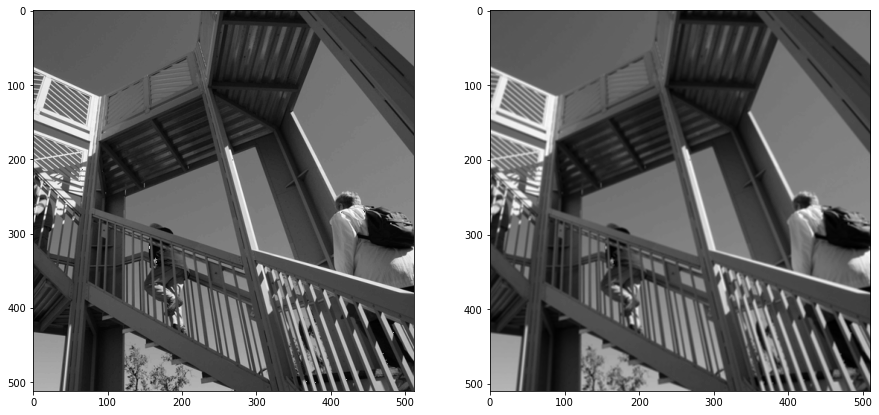

In [28]:
#平滑化フィルターの実装
input_array = misc.ascent() #画像取得
print("入力画像の形状",input_array.shape) #入力形状の確認

#平滑化フィルター
filter_array = np.array([[1/9,1/9,1/9],
                         [1/9,1/9,1/9],
                         [1/9,1/9,1/9]])

plt.figure(figsize=(15,15))

#入力画像の描画
plt.subplot(1,2,1)
plt.gray()
plt.imshow(input_array)

#畳み込み演算
output_array = signal.convolve2d(input_array, filter_array,"valid")

#出力画像の描画
print("出力画像の形状",output_array.shape) #出力形状の確認
plt.subplot(1,2,2)
plt.imshow(output_array)
plt.show()

このように，平滑化フィルターを用いることで画像を平滑化（ぼかし）できていることが確認できる。

2. 縦線検出フィルター
  - エッジ（縦線）検出に用いる。<br><br>
<center><img src = "https://github.com/Toshiki-Keio/introduction-to-deep-learning/blob/main/day4/chapter2/edge_vertical.png?raw=true" width = "80%"></center><br>

入力画像の形状 (512, 512)
出力画像の形状 (510, 510)


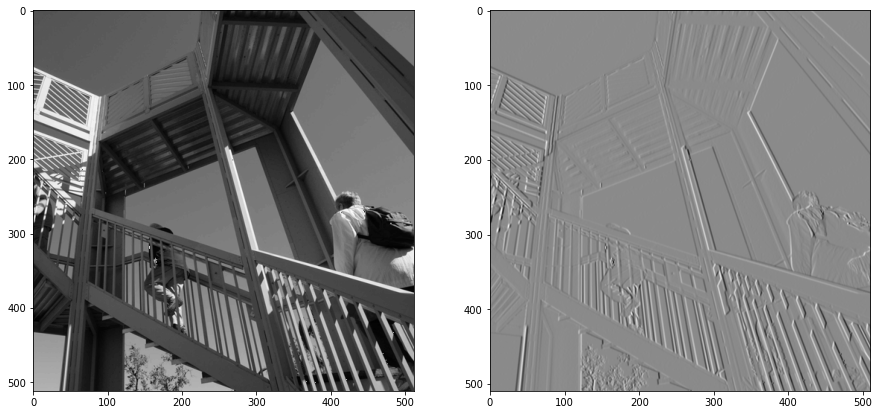

In [29]:
#縦線検出フィルターの実装
input_array = misc.ascent() #画像取得
print("入力画像の形状",input_array.shape) #入力形状の確認

#縦線検出フィルター
filter_array = np.array([[1,0,-1],
                         [2,0,-2],
                         [1,0,-1]])

plt.figure(figsize=(15,15))

#入力画像の描画
plt.subplot(1,2,1)
plt.gray()
plt.imshow(input_array)

#畳み込み演算
output_array = signal.convolve2d(input_array, filter_array,"valid")

#出力画像の描画
print("出力画像の形状",output_array.shape) #出力形状の確認
plt.subplot(1,2,2)
plt.imshow(output_array)
plt.show()

3. 横線検出フィルター
  - エッジ（横線）検出に用いる。<br><br>
<center><img src = "https://github.com/Toshiki-Keio/introduction-to-deep-learning/blob/main/day4/chapter2/edge_horizontal.png?raw=true" width = "80%"></center><br>

入力画像の形状 (512, 512)
出力画像の形状 (510, 510)


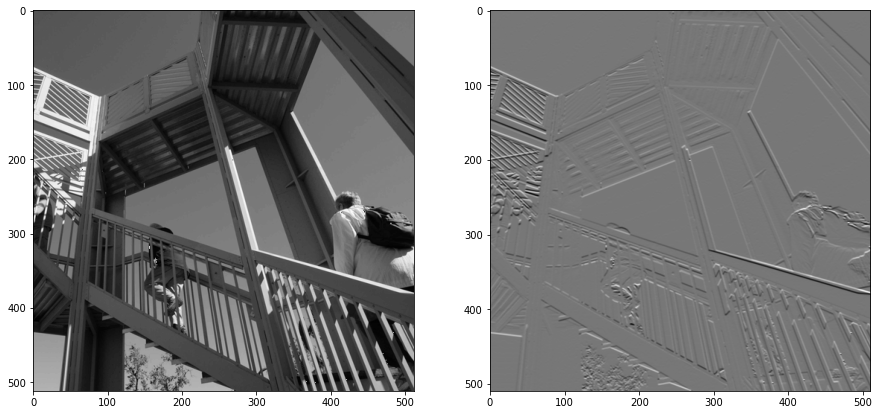

In [30]:
#横線検出フィルターの実装
input_array = misc.ascent() #画像取得
print("入力画像の形状",input_array.shape) #入力形状の確認

#縦線検出フィルター
filter_array = np.array([[1,2,1],
                         [0,0,0],
                         [-1,-2,-1]])

plt.figure(figsize=(15,15))

#入力画像の描画
plt.subplot(1,2,1)
plt.gray()
plt.imshow(input_array)

#畳み込み演算
output_array = signal.convolve2d(input_array, filter_array,"valid")

#出力画像の描画
print("出力画像の形状",output_array.shape) #出力形状の確認
plt.subplot(1,2,2)
plt.imshow(output_array)
plt.show()

このように、画像データに対して行いたいフィルタリングを考えフィルターを決定する必要がある。ただし、CNNにおいては、フィルタはパラメータ化されており、誤差逆伝播法によりフィルターを獲得する。（後述）

## バイアス
全結合ニューラルネットワークの理論を振り返ると、入力に重みを乗算し、その値にバイアスを加算することで出力を決定していた。<br>
CNNの場合も同様に考えることができ、上記のフィルターが重みに該当する。<br>
バイアスも考慮すると、以下のような処理を行うことができる。<br><br>

<center><img src = "https://github.com/Toshiki-Keio/introduction-to-deep-learning/blob/main/day4/chapter2/conv_bias.png?raw=true" width = "80%"></center><br>

上図のように、バイアスの加算は、フィルター適用後のデータに対して行われる。<br>
バイアスの値は常に1つだけであり、フィルター適用後のすべての要素に同じ値が加算される。<br><br>

尚、一般的なCNNにおいては、フィルターもバイアスもパラメータ化され、学習により最適なフィルターを獲得する。以下の画像のように、効果的なフィルターが重み(フィルター)とバイアスで構成されているとみなせば、誤差逆伝播的に最適なパラメータが求まり、最適なフィルターを取得することができる。そのため、実装上ではフィルターサイズを設定するだけで最適なフィルターが自動的に実装されるのである。<br><br>

<center><img src = "https://github.com/Toshiki-Keio/introduction-to-deep-learning/blob/main/day4/chapter2/opt_filter.png?raw=true" width = "70%"></center><br>

## パディング
畳み込み演算について学んだが、例えば(4,4)の画像に(3,3)のフィルターを適用した場合を考えると、出力サイズは(2,2)となる。<br>
このことから、入力データにフィルターを何度も適用していくと、最終的に出力サイズが1になってしまう可能性があることが容易に想像できる。そこで行う対策処理として**パディング**というものがある。<br>
パディングとは、入力データの周囲を固定の値(一般的に0が用いられる)で埋めることで、出力データのサイズを保つ処理方法である。パディング処理は以下のようなイメージである。尚。今回は幅1、0で埋めた場合のパディング処理を示している。<br><br>

<center><img src="https://github.com/Toshiki-Keio/introduction-to-deep-learning/blob/main/day4/chapter2/padding.png?raw=true" width = "80%"></center><br>

このように、パディングを行うことで(4,4)のデータに(3,3)のフィルターを適用しても、出力サイズを(4,4)に保つことが確認できる。

## ストライド
ストライドとは、フィルターの適用する間隔のことである。これまでの例では、フィルターを1マス間隔で適用しており、ストライドが1の例だった。(7,7)の入力画像に対し、(3,3)のフィルターをパディングを0、ストライドを2として適用すると、出力サイズは(3,3)となる。<br>このように、ストライドは**出力サイズを調整**するために用いられる。<br><br>

<center><img src = "https://github.com/Toshiki-Keio/introduction-to-deep-learning/blob/main/day4/chapter2/stride.gif?raw=true" width = "80%"></center><br>


このように、畳み込み層ではフィルターサイズ、パディング、ストライドというハイパーパラメータを調整することで、出力サイズを調整することができる。入力データのサイズを(${IH}$,${IW}$)、フィルターサイズを(${FH}$,${FW}$)、パディングを${P}$、ストライドを${S}$、出力サイズを(${OH}$,${OW}$)とすれば、一般に以下の式を用いて出力サイズを算出することができる。<br><br>
\begin{equation}
{OH=\frac{IH+2P-FH}{S}+1}
\end{equation}
\begin{equation}
{OW=\frac{IW+2P-FW}{S}+1}
\end{equation}<br>

実際に先の例を当てはめてみると、${IH=IW=7}$、${FH=FW=3}$、${P=0}$、${S=2}$なので、<br><br>
\begin{equation}
{OH=\frac{7+2\cdot{0}-3}{2}+1}=3
\end{equation}
\begin{equation}
{OW=\frac{7+2\cdot{1}-3}{2}+1}=3
\end{equation}<br>

となり、出力サイズが(3,3)になることが確認できる。

# 第3章 プーリング層




## プーリング層概要
第3章では、畳み込み層の後に用いられることの多いプーリングについて説明する。<br>
プーリングとは、情報の集約処理を行うことで画像サイズを小さくする処理のことである。定義からも分かるように、プーリングを行うことで、<br>

- 画像サイズを小さくできる
- 特徴点を抽出できる<br>

というメリットがある。プーリングのイメージは下図の通りである。尚、下記の例は2×2のMaxプーリングをパディング0、ストライド2で行った例である。<br><br>

<center><img src = "https://github.com/Toshiki-Keio/introduction-to-deep-learning/blob/main/day4/chapter3/maxpooling.png?raw=true" width = "70%"></center><br>

プーリングでは、上記のようにある領域を考え、その領域に対して処理するが、パラメータ化すべき要素がないため、畳み込み層におけるフィルターのように学習すべきパラメータが存在しないことが特徴としてあげられる。<br>上記の例では、入力データに対し、2×2の領域を考え、その領域の最大値を抽出したものが出力データとして獲得できる。このように、ある領域を考え、その領域の最大値を抽出する処理をMaxプーリングと呼ぶ。<br><br>
プーリングにはその他にも、対象領域の平均値を抽出する**Averageプーリング**などの種類がある。どちらもある領域を考える点、学習すべきパラメータがないという点では共通だが、領域内の最大値をとるか平均値をとるかという違いがある。**画像処理分野では特にMaxプーリングが行われることが多い。**<br><br>
また一般的に、**プーリングのウィンドウサイズとストライドは同じ値に設定する。**特にフィルターのサイズは(2,2)、パディング0、ストライド2とすることが多い。（画像サイズを半分にすることができるため）<br>

## プーリング層実装
今回はプーリング層の実装として、Max PoolingとしてPyTorchのMaxPool2d、Average PoolingとしてAvgPool2dを用いる。<br>
尚、どちらもテンソル仕様のため、プログラム中でnumpy→Tensorの変換を行っている。

### MaxPooling

In [31]:
#モジュールのインポート
from scipy import misc
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

入力画像の形状 (512, 512)
出力画像の形状 (256, 256)


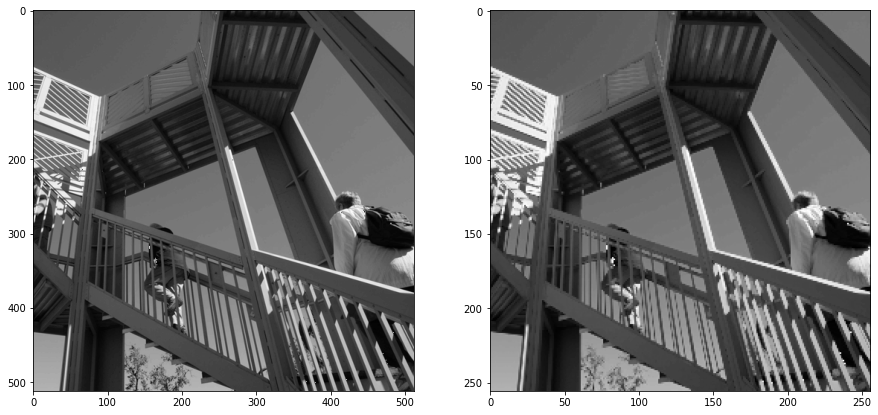

In [32]:
#プーリング層1回実行
input_array_numpy = misc.ascent() #画像取得
print("入力画像の形状",input_array_numpy.shape) #入力形状の確認

plt.figure(figsize=(15,15))

#入力画像の描画
plt.subplot(1,2,1)
plt.imshow(input_array_numpy)

#maxpooling処理
input_array = torch.reshape(torch.from_numpy(input_array_numpy.astype(np.float32)),(1,512,512)) #入力データをTensor形式に変換
m = nn.MaxPool2d(2) #maxpooling処理を変数mに格納
output_array = m(input_array).numpy() #maxpooling処理実行&numpy形式に変換
output_array_numpy = np.reshape(output_array,(256,256)) #一回maxpooling処理を行ったため、出力は(256,256)になっている。

#出力画像の描画
print("出力画像の形状",output_array_numpy.shape) #出力形状の確認
plt.subplot(1,2,2)
plt.imshow(output_array_numpy)
plt.show()

入力画像の形状 (512, 512)
出力画像の形状 (32, 32)


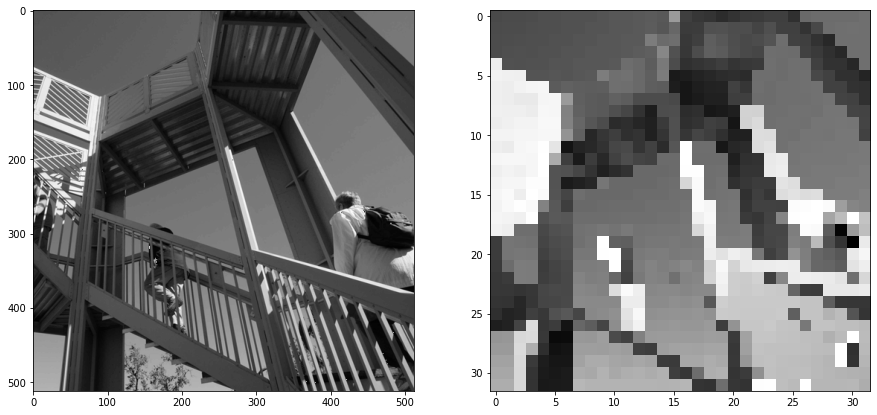

In [33]:
#プーリング層4回実行
input_array_numpy = misc.ascent() #画像取得
print("入力画像の形状",input_array_numpy.shape) #入力形状の確認

plt.figure(figsize=(15,15))

#入力画像の描画
plt.subplot(1,2,1)
plt.imshow(input_array_numpy)

#maxpooling処理
input_array = torch.reshape(torch.from_numpy(input_array_numpy.astype(np.float32)),(1,512,512)) #入力データをTensor形式に変換
m = nn.MaxPool2d(2) #maxpooling処理を変数mに格納
for i in range(4):
   input_array = m(input_array) #maxpooling処理実行


output_array = input_array.numpy() #numpy形式に変換
output_array_numpy = np.reshape(output_array,(32,32)) #4回maxpooling処理を行ったため、出力は(8,8)になっている。（512→256→128→64→32）

#出力画像の描画
print("出力画像の形状",output_array_numpy.shape) #出力形状の確認
plt.subplot(1,2,2)
plt.imshow(output_array_numpy)
plt.show()

### AveragePooling

入力画像の形状 (512, 512)
出力画像の形状 (32, 32)


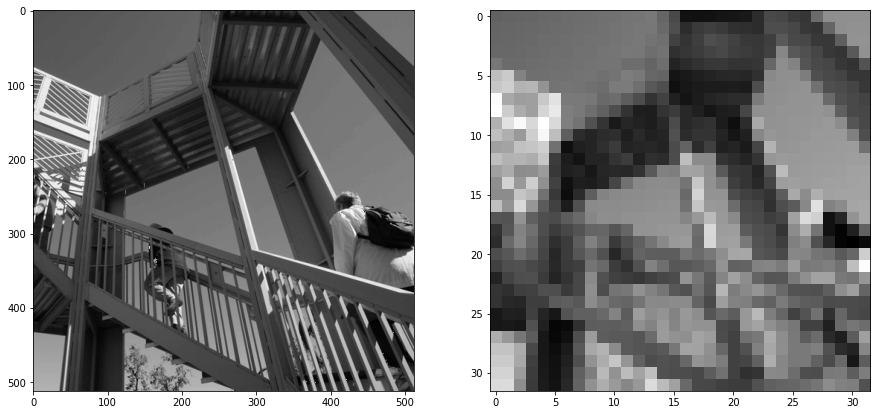

In [34]:
#プーリング層4回実行
input_array_numpy = misc.ascent() #画像取得
print("入力画像の形状",input_array_numpy.shape) #入力形状の確認

plt.figure(figsize=(15,15))

#入力画像の描画
plt.subplot(1,2,1)
plt.imshow(input_array_numpy)

#maxpooling処理
input_array = torch.reshape(torch.from_numpy(input_array_numpy.astype(np.float32)),(1,512,512)) #入力データをTensor形式に変換
m = nn.AvgPool2d(2) #averagepooling処理を変数mに格納
for i in range(4):
   input_array = m(input_array) #maxpooling処理実行


output_array = input_array.numpy() #numpy形式に変換
output_array_numpy = np.reshape(output_array,(32,32)) #4回maxpooling処理を行ったため、出力は(8,8)になっている。（512→256→128→64→32）

#出力画像の描画
print("出力画像の形状",output_array_numpy.shape) #出力形状の確認
plt.subplot(1,2,2)
plt.imshow(output_array_numpy)
plt.show()

このように、Max PoolingとAverage Poolingの出力結果を比較すると、Max Poolingでは特徴量が抽出されている一方、Average Poolingでは画像全体の情報が圧縮されたような結果になっていることが確認できる。このような両者の特徴を踏まえ、プーリング層で行う処理は目的に応じて考える必要があると言える。

# 第4章 CNNの実装(MNIST)
第4章では、第3章までの内容を踏まえ実際にCNNを実装してみよう。今回はPytorchを用いてCNNの実装を行う。<br>
本章では第3章でも用いたMNISTデータセットに対してCNNの実装を行う。これにより画像データに対して学習を行う際、全結合ニューラルネットワークではなくCNNを用いることが有用であることを確認する。

## モジュールのインポートとGPU対応の確認
まず、モジュールのインポートとGPU対応の確認を行う。
  - PytorchではGPUモードを明示的に指定する必要あり


In [35]:
#モジュールのインポート
import torch
from torch import nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

#GPUチェック
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #デバイスとしてGPU(cuda)かCPUか判定
print("デバイスの種類：",device)

デバイスの種類： cuda


## ハイパーパラメータの設定
学習において調整が必要なハイパーパラメータに関しても最初に定義しておく。
ハイパーパラメータとして、ここでは以下の3つを定義する。
- エポック数
  - 学習回数
- バッチサイズ
  - データローダ作成時に使用
- 学習率
  - 誤差逆伝播におけるパラメータ更新割合の設定

In [36]:
NUM_EPOCHS = 20 #学習時のエポック数
BATCH_SIZE = 100 #バッチサイズ
LEARNING_RATE = 0.001 #学習率

## データセットの用意
第3章と同様にMNISTのデータセットを読み込む。
  - DataLoaderを作成

In [37]:
#MNISTデータセットの読み込み
train_datasets = datasets.MNIST(root="mnistdata", #ダウンロード先
                                train=True, #学習用データが否か
                                transform=transforms.ToTensor(), #データへの処理を記述。今回はデータをテンソル形式に変換。正規化したりもする。
                                download=True) #ダウンロードするかどうか
print("学習データ")
print(train_datasets)                                
test_datasets = datasets.MNIST(root="mnistdata",
                                train=False,
                                transform=transforms.ToTensor())
print()
print("テストデータ")
print(test_datasets)

#DataLoaderへ変更
train_loader = DataLoader(dataset=train_datasets, #データセット
                           batch_size=BATCH_SIZE, #バッチサイズ
                           shuffle=False) #シャッフルするかどうか。Falseの場合、再現性ありとなる。
test_loader = DataLoader(dataset=test_datasets,
                           batch_size=BATCH_SIZE,
                           shuffle=False)

学習データ
Dataset MNIST
    Number of datapoints: 60000
    Root location: mnistdata
    Split: Train
    StandardTransform
Transform: ToTensor()

テストデータ
Dataset MNIST
    Number of datapoints: 10000
    Root location: mnistdata
    Split: Test
    StandardTransform
Transform: ToTensor()


## 学習モデル作成
入力画像が(28,28)、カーネルサイズ5×5、パディング2、ストライド1とすると、画像サイズの変化は以下のようになる。
- 畳み込み層1
\begin{equation}
{\frac{28+2\cdot{2}-5}{1}+1=28}
\end{equation}
- プーリング層1
\begin{equation}
{\frac{28}{2}=14}
\end{equation}
- 畳み込み層2
\begin{equation}
{\frac{14+2\cdot{2}-5}{1}+1=14}
\end{equation}
- プーリング層2
\begin{equation}
{\frac{14}{2}=7}
\end{equation}
- 全結合層
\begin{equation}
{7\cdot{7}\cdot{32}}
\end{equation}


In [38]:
#CNNモデル作成
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2), #畳み込み (input_channels, output_channels,kernel_size, padding)
            nn.BatchNorm2d(16), #Batch Normalization
            nn.ReLU(), #活性化関数
            nn.MaxPool2d(2)) #Maxプーリング
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2), #畳み込み (input_channels, output_channels,kernel_size, padding)
            nn.BatchNorm2d(32), #Batch Normalization
            nn.ReLU(), #活性化関数
            nn.MaxPool2d(2)) #Maxプーリング
        self.fc = nn.Sequential( #Affine
            nn.Linear(7 * 7 * 32, 100),
            nn.ReLU(),
            nn.Linear(100, 10))
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) #テンソルの形を変換
        out = self.fc(out)
        return out

model = CNN().to(device) #GPUに送る
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1568, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)

## 最適化アルゴリズム、損失関数設定
- 損失関数としては交差エントロピー誤差
- パラメータ更新のための最適化アルゴリズムとしてはadam

In [39]:
criterion = nn.CrossEntropyLoss()#交差エントロピー誤差
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)#adam

## 学習実行
Batch NormalizationやDropoutなど学習時と推論時で挙動が変わるレイヤを用いる場合には，モデルのモードに注意してきちんと切り替える必要がある。
  - model.train()で訓練モード
  - model.eval()で評価モード

一般的な学習の流れを以下にまとめておく。<br><br>

**【訓練モード】**
1. 訓練モード指定
2. 画像データ、ラベルをGPUに送る
3. テンソル勾配のクリア
4. CNNモデルに入力画像を入れて出力を算出
5. 学習ロス計算
6. 誤差逆伝播
7. 最適化アルゴリズムを用いてパラメータ更新<br>

**【評価モード】**
1. 評価モード指定
2. テンソルの勾配計算を不可能にする
  - 必須ではないが、GPUでは処理速度やメモリ効率の影響が大きいため、やった方が効率的）
3. 画像データ、ラベルをGPUに送る
4. CNNモデルに入力画像を入れて出力を算出
5. 学習ロス、精度計算



In [40]:
def train(train_loader):
    model.train() #訓練モードを指定
    running_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader): #学習データの画像、ラベルをDataLoaderから取得
        images = images.to(device) #GPUにいれる
        labels = labels.to(device) #GPUにいれる
        optimizer.zero_grad() #テンソル勾配のクリア
        outputs = model(images) #CNNモデルを用いて計算
        loss = criterion(outputs, labels) #ロス計算
        running_loss += loss.item()
        loss.backward() #誤差逆伝播
        optimizer.step() #パラメータ更新
    train_loss = running_loss / len(train_loader) 
    return train_loss

def valid(test_loader):
    model.eval() #評価モードを指定
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad(): #テンソルの勾配計算を不可能にすることでメモリの消費量を減らす、optimizer.zero_grad()がいらなくなる
        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = outputs.max(1, keepdim=True)[1]
            correct += predicted.eq(labels.view_as(predicted)).sum().item() #精度を計算
            total += labels.size(0)
    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    return val_loss, val_acc

loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(NUM_EPOCHS):
    loss = train(train_loader)
    val_loss, val_acc = valid(test_loader)
    print('Epoch %d, Loss: %.4f Val_loss: %.4f Val_acc: %.4f' % (epoch, loss, val_loss, val_acc))
    #損失、精度をリストに格納
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
print("訓練終了")

#学習結果をnpy形式で、学習モデルをpkl形式で保存
np.save('loss_list.npy', np.array(loss_list))
np.save('val_loss_list.npy', np.array(val_loss_list))
np.save('val_acc_list.npy', np.array(val_acc_list))
torch.save(model.state_dict(), 'cnn.pkl')

Epoch 0, Loss: 0.1488 Val_loss: 0.0624 Val_acc: 0.9802
Epoch 1, Loss: 0.0505 Val_loss: 0.0432 Val_acc: 0.9871
Epoch 2, Loss: 0.0356 Val_loss: 0.0383 Val_acc: 0.9877
Epoch 3, Loss: 0.0264 Val_loss: 0.0336 Val_acc: 0.9891
Epoch 4, Loss: 0.0207 Val_loss: 0.0409 Val_acc: 0.9878
Epoch 5, Loss: 0.0171 Val_loss: 0.0496 Val_acc: 0.9846
Epoch 6, Loss: 0.0156 Val_loss: 0.0446 Val_acc: 0.9868
Epoch 7, Loss: 0.0136 Val_loss: 0.0430 Val_acc: 0.9892
Epoch 8, Loss: 0.0115 Val_loss: 0.0343 Val_acc: 0.9909
Epoch 9, Loss: 0.0103 Val_loss: 0.0345 Val_acc: 0.9914
Epoch 10, Loss: 0.0077 Val_loss: 0.0371 Val_acc: 0.9897
Epoch 11, Loss: 0.0081 Val_loss: 0.0347 Val_acc: 0.9904
Epoch 12, Loss: 0.0067 Val_loss: 0.0410 Val_acc: 0.9889
Epoch 13, Loss: 0.0064 Val_loss: 0.0400 Val_acc: 0.9902
Epoch 14, Loss: 0.0086 Val_loss: 0.0398 Val_acc: 0.9900
Epoch 15, Loss: 0.0056 Val_loss: 0.0372 Val_acc: 0.9917
Epoch 16, Loss: 0.0041 Val_loss: 0.0609 Val_acc: 0.9870
Epoch 17, Loss: 0.0055 Val_loss: 0.0446 Val_acc: 0.9900
Ep

## 結果表示

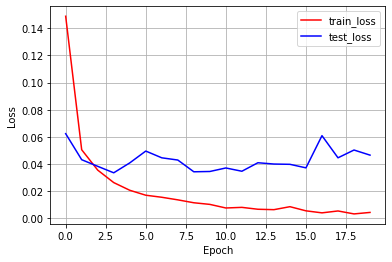

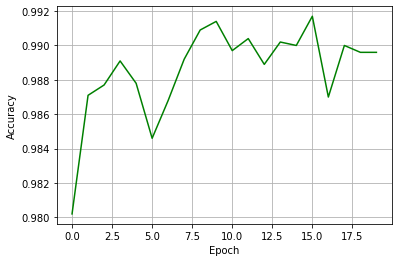

In [41]:
# 学習データに対するロス、テストデータに対するロス
plt.figure()
plt.plot(range(NUM_EPOCHS), loss_list, 'r-', label='train_loss')
plt.plot(range(NUM_EPOCHS), val_loss_list, 'b-', label='test_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

#正解率
plt.figure()
plt.plot(range(NUM_EPOCHS), val_acc_list, 'g-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

以上の結果を第3回で実装したDNNによる分類精度と比較すると、DNNが98%の精度だったのに対しCNNは99%の精度を実現できていることが分かる。これにより、画像処理に対しCNNが有用であることが確認できた。実際にテストデータの正解値と推定値を表示してみる。

正解ラベルの種類： {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
正解ラベル： [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9]
推定ラベル： [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9]


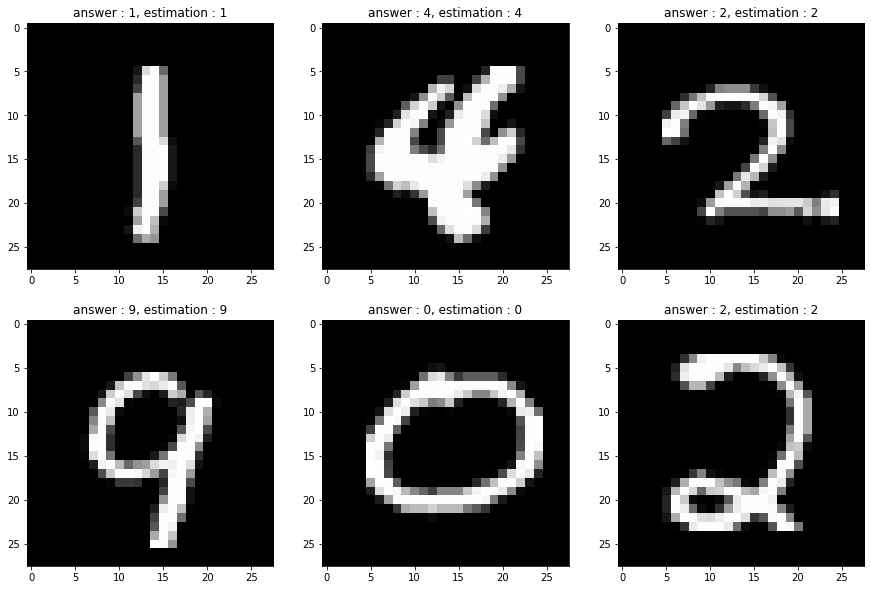

In [42]:
#テストデータ取得
images, labels = iter(test_loader).next()
images = images.to(device)
labels = labels.tolist()
print("正解ラベルの種類：",set(labels))
print("正解ラベル：",labels)

#学習済みモデル取得
model2 = CNN().to(device)
model2.load_state_dict(torch.load("cnn.pkl")) #pkl形式で学習済みモデルを出力

#学習済みモデルによる推定
outputs = model2(images)
est_results = torch.argmax(outputs, dim=1)
est_results = est_results.tolist()
print("推定ラベル：",est_results)

#画像の正解ラベル、推定ラベル描画
plt.figure(figsize = (15,10))
img_num=1
while img_num < 7:
  #画像表示
  i = np.random.randint(1,100)
  img = images[i].to('cpu').detach().numpy()
  img = np.squeeze(img)
  plt.subplot(2,3,img_num)
  #結果出力
  plt.title("answer : "+str(labels[i])+", estimation : "+str(est_results[i]))
  plt.imshow(img)
  img_num+=1
plt.show()

このように、どの文字も適切に分類できていることが分かる。

## 自分の手書き文字判別
最後に，MNISTを用いて作成したCNNモデルを用いて，自分で手書きした文字の判別ができるか試す。<br>
まず，githubに上げた著者の手書き画像を取得する。

In [43]:
!wget -nc https://github.com/Toshiki-Keio/introduction-to-deep-learning/raw/main/day4/chapter4/handwritten1.jpg
!wget -nc https://github.com/Toshiki-Keio/introduction-to-deep-learning/raw/main/day4/chapter4/handwritten2.jpg
!wget -nc https://github.com/Toshiki-Keio/introduction-to-deep-learning/raw/main/day4/chapter4/handwritten3.jpg

File ‘handwritten1.jpg’ already there; not retrieving.

File ‘handwritten2.jpg’ already there; not retrieving.

File ‘handwritten3.jpg’ already there; not retrieving.



次に，ダウンロードした手書き文字を学習済みモデルに入れ推定結果を見る。<br>
尚，今回手書きした文字は7,8,6である。

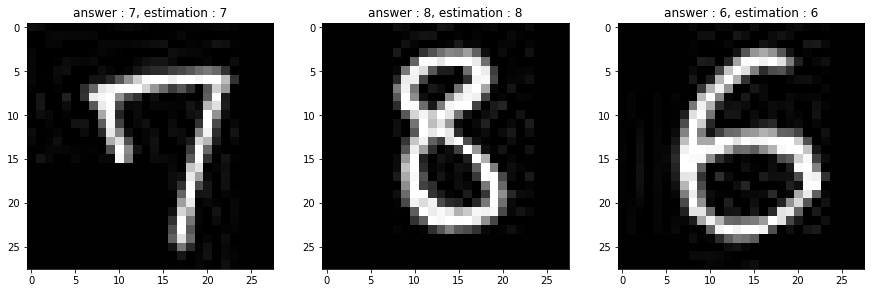

In [44]:
import cv2
import matplotlib.pyplot as plt

answer_list = ["7","8","6"]
plt.figure(figsize=(15,15))

for i in range(3):
  img = cv2.imread("handwritten"+str(i+1)+".jpg")
  img = cv2.bitwise_not(img)
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #グレースケールに変換
  hand_img = torch.from_numpy(np.reshape(gray_img,(1,1,28,28)).astype(np.float32))
  hand_img = hand_img.to(device)
  outputs = model2(hand_img)
  est_result = torch.argmax(outputs, dim=1)
  plt.subplot(1,3,i+1)
  plt.imshow(gray_img)
  plt.title("answer : "+answer_list[i]+", estimation : "+str(est_result.item()))
plt.show()

このように，学習済みモデルを用いて自作データセットの分類も正確に行えることが確認できた。皆さんも是非自分自身の手書き文字に対し分類が上手く行くか試してみてほしい。

# 第5章 転移学習
本章では補足的な内容として転移学習(Transfer Learning)について説明する。


## 転移学習概要
転移学習とは、学習済みの重みの一部を別のニューラルネットワークにコピーし再学習を行うことで、効率的な学習を行う方法である。一度学習したものを別のものに使い回す方法のため、一般的な機械学習と比較して以下のようなメリットがある。<br><br>

- 学習時間を短時間化できる
  - **転移元と転移先の関連性が高く、転移元が十分に学習されたモデルであれば**、少ないデータセット&短時間で学習可能。
    - 「テニス経験がある人が類似スポーツのバトミントンを習得するのにかかる時間は、テニス経験がない人がバトミントンを習得するまでにかかる時間よりも短時間である」というイメージ。
- データセットが少なくても高精度
  - 機械学習を行う上では大量のデータセットがあることが重要だが、大量のデータセットを取得するには膨大な時間がかかる。転移学習を用いる場合、学習済みモデルを用いることができるため、追加できるデータセットが少ない場合でもモデル構築が可能。<br><br>

このように、転移学習は一般的な機械学習と比較して非常に有用性があることが分かる。ただし、転移学習は必ず良い結果を産むとは限らない。転移学習のメリットが発揮されるのは転移元と転移先の関連性が高い場合であり、仮に関連性が低かった場合、**負の転移(negative transfer)**と呼ばれる状況が発生し、精度の改善ではなくかえって悪化をもたらす可能性がある。そのため、転移学習をしたモデルとしなかったモデルで精度を比較し、負の転移が起こっているかどうか確認する必要がある。

## ディープラーニングにおける転移学習の分類
ディープラーニングにおける転移学習といえば、一般的に**ネットワークベース転移学習**のことを指す。以下、ネットワークベース転移学習について説明する。<br><br>

**ネットワークベース転移学習**<br>
ネットワークベース転移学習には、以下の2種類がある。
- 事前学習済みネットワークベース転移学習
  - 学習済みモデルのパラメータは固定し、新たに追加した層のみ学習する方法<br><br>

<center><img src = "https://github.com/Toshiki-Keio/introduction-to-deep-learning/blob/main/day4/chapter5/transferlearning.png?raw=tru" width="80%"></center>

- 事前学習済みネットワークの微調整(Fine Tuning)
  - 学習済みモデルのパラメータを初期値として、モデル全体のパラメータを微調整する方法<br>

<center><img src = "https://github.com/Toshiki-Keio/introduction-to-deep-learning/blob/main/day4/chapter5/finetuning.png?raw=true" width="80%"></center>

尚、データセットのサイズが小さい場合、ファインチューニングを行うと過学習を引き起こす可能性があるため、データセットサイズ次第で事前学習済みネットワークベース転移学習かファインチューニングかを使い分ける必要がある。<br><br>

その他にも、インスタンスベース転移学習、地図ベース転移学習、敵対ベース転移学習など転移学習にも様々な種類があるがここでは割愛する。興味があれば是非調べて欲しい。




## 転移学習実装
転移学習の概要を踏まえ、実装を行う。<br>
今回は、データセットとしてMNISTではなく、CIFAR-10というカラー画像データセットを用いる。CIFAR-10とは，ラベル付きの6万枚のカラー画像により構成されるデータセットで，画像サイズは(32,32)，画像の種類は10種類（plane, car, bird, cat, deer,dog, frog, horse, ship, truck）となっている。CIFAR-10の画像は以下のようなものである。<br><br>

<center><img src = "https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png" width = "60%"></center><br>


（引用） [CIFAR-10 - Object Recognition in Images | Kaggle](https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png)<br><br>

このCIFAR-10を題材に転移学習の実装を行う。今回は学習済みモデルとして有名なVGGをを用いて転移学習の実装を行おう。<br>
まず、いつも通りモジュールのインポート、ハイパーパラメータの設定を行う。

**モジュールのインポート**

In [11]:
#モジュールのインポート
import torch
from torch import nn
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2

#GPUチェック
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #デバイスとしてGPU(cuda)かCPUか判定
print("デバイスの種類：",device)

デバイスの種類： cuda


**ハイパーパラメータの設定**

In [12]:
NUM_EPOCHS = 20 #学習時のエポック数
BATCH_SIZE = 16 #バッチサイズ
LEARNING_RATE = 0.001 #学習率

**データセットの読み込み**

今回、転移学習の有用性を示すため、データに対して以下の2つの処理を施す。
- CIFAR-10データセットを読み込む際、データサイズを(64,64)に変形
  - 画像サイズが小さすぎると畳み込み層からの出力サイズが非常に小さくなってしまう。（出力サイズが(1,1)になったりするが、これでは画像の特徴量データとして非常に少ない）<br>今回転移学習に用いるVGGは**チャンネル3、画像サイズ32以上のデータに対して用いることができる学習済みモデル**であり、CIFAR-10の(32,32)サイズでも問題はないのだが、(64,64)にリサイズすることで学習性能を向上させている。
- データセットの数(datapoints)を1000に縮小
  - 転移学習概要で、転移学習はデータセットが少ない時に有用であると説明した。このことを示すため、今回は学習用データセットを大幅に削減した。テストデータはそのままにした。

In [13]:
#CIFAR-10データセットの読み込み
transform = transforms.Compose([
                                transforms.Resize(64), #画像サイズを(64,64)に変換
                                transforms.ToTensor()]) #画像データをテンソル型に変換

train_datasets = datasets.CIFAR10(root="cifar10data", #ダウンロード先
                                train=True, #学習用データが否か
                                transform=transform,#データへの処理を記述
                                download=True) #ダウンロードするかどうか
                        
test_datasets = datasets.CIFAR10(root="cifar10data",
                                train=False,
                                transform=transform)
print("---------処理前---------")
print("学習データ（画像）:",train_datasets.data.shape)
print("学習データ（ラベル）",len(train_datasets.targets))
print("検証データ（画像）:",test_datasets.data.shape)
print("検証データ（ラベル）",len(test_datasets.targets))

#データセットの量を1000枚に変更
train_datasets.data = train_datasets.data[:1000]
train_datasets.targets = train_datasets.targets[:1000]
print()
print("---------処理後---------")
print("学習データ（画像）:",train_datasets.data.shape)
print("学習データ（ラベル）",len(train_datasets.targets))
print("検証データ（画像）:",test_datasets.data.shape)
print("検証データ（ラベル）",len(test_datasets.targets))


#DataLoaderへ変更
train_loader = DataLoader(dataset=train_datasets, #データセット
                           batch_size=BATCH_SIZE, #バッチサイズ
                           shuffle=False) #シャッフルするかどうか。Falseの場合、再現性ありとなる。
test_loader = DataLoader(dataset=test_datasets,
                           batch_size=BATCH_SIZE,
                           shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10data/cifar-10-python.tar.gz to cifar10data
---------処理前---------
学習データ（画像）: (50000, 32, 32, 3)
学習データ（ラベル） 50000
検証データ（画像）: (10000, 32, 32, 3)
検証データ（ラベル） 10000

---------処理後---------
学習データ（画像）: (1000, 32, 32, 3)
学習データ（ラベル） 1000
検証データ（画像）: (10000, 32, 32, 3)
検証データ（ラベル） 10000


このように、学習データが1000セットに減少したことが確認できる。尚、ここでは画像サイズが(32,32)のままで変わっていないが、学習部分で`print(images.size())`と記述すると画像サイズが(64,64)にリサイズされていることが確認できる。
また、データセットに含まれた画像を確認する。

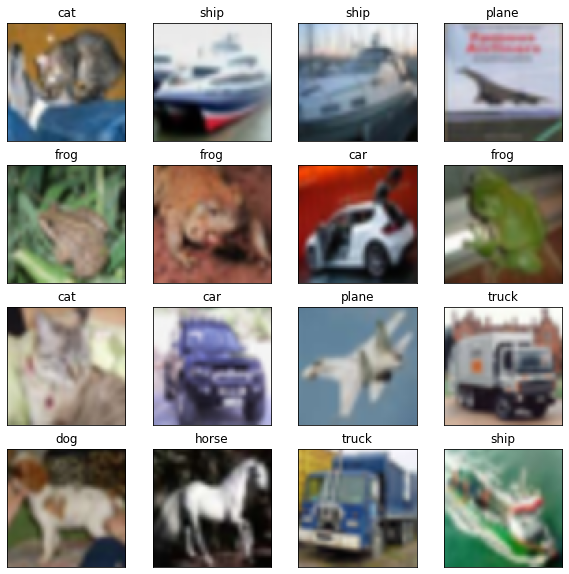

In [14]:
#CIFAR-10の図確認
classes = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck') #CIFAR-10で用いられるラベル
plt.figure(figsize=(10,10)) #画像の表示サイズ
chkdata = iter(test_loader)
chkimages, chklabels = chkdata.next() #イテレータから最初のバッチを取り出す
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(np.transpose(chkimages[i], (1, 2, 0)))
    label = classes[chklabels[i]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False) #ラベルとメモリを非表示にする
plt.show()

**学習モデルの作成**

転移元の学習済みモデルとしてVGG19を用いる。VGG19とは，ILSVRC2014という画像処理分野における国際的なコンペティションで一位を獲得したモデルで，下図のように畳み込み層16層+全結合層3層=19層で構成されているため、19と名付けられている。VGG19の構造は以下の画像のようになっている。<br><br>

<center><img src="https://github.com/Toshiki-Keio/introduction-to-deep-learning/blob/main/day4/chapter5/vgg19.png?raw=" width="60%"></center><br><br>

(引用) [Illustration of the network architecture of VGG-19 model: conv means convolution, FC means fully connected](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.researchgate.net%2Ffigure%2Fllustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means_fig2_325137356&psig=AOvVaw0J3dW_eP-h3vaAMxg6aq39&ust=1651856213313000&source=images&cd=vfe&ved=0CAwQjRxqFwoTCOiHy4nqyPcCFQAAAAAdAAAAABAg)

VGGにはそのほかにもVGG11,13,16などがある。VGGの種類，精度に関しては以下の論文を参考にすると分かりやすい。

（参考）[Karen Simonyan,Andrew Zisserman, "VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION",ICLR 2015](https://arxiv.org/pdf/1409.1556.pdf)<br>

さて，まずVGG19の中身を確認する。尚、今回はBatch Normalizationが用いられたVGG19_BNを用いている。

In [ ]:
#VGG19の中身を確認
model = models.vgg19_bn(pretrained = True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

VGG19の構造を見ると、classifierの出力が1000個あることが分かる。しかし、CIFAR-10は10種類分類のため、モデルの出力サイズを10に変更する必要があることが分かる。出力サイズは以下のように変更することができる。<br>
また、下ではモデルにおいて全体のパラメータを固定した後、全結合層のパラメータのみTrueにすることで、事前学習済みネットワークベース転移学習を実装している。ここで全体のパラメータを固定せず再学習する場合がFine Tuningである。

In [ ]:
#転移学習モデル作成（モデルの出力ノード変更）
model.classifier[6].out_features =10 #モデルの出力ノードを10個に変更
for param in model.parameters(): #全パラメータを固定
    param.requires_grad = False
for param in model.classifier.parameters(): #全結合層のパラメータのみ学習
    param.requires_grad = True

model = model.to(device)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

このように、classifierのout_featuresが10に変更されたことが確認できる。

**損失関数，最適化アルゴリズム設定**



一般的にディープラーニニングではAdamを用いるケースが多いが、転移学習の場合SGDの方が良い結果になったという事例も多く報告されているため、今回は最適化アルゴリズムとしてSGDを用いる。<br>
また、今回は畳み込み層のパラメータは固定し学習せず、全結合層のパラメータのみ学習する。その際、最適化アルゴリズムに渡すパラメータに固定パラメータを含める（`model.parameters()`と記述する）とエラーが出るため、以下のようにclassifierのパラメータであることを明示する必要がある。

In [ ]:
criterion = nn.CrossEntropyLoss() #交差エントロピー誤差
optimizer = torch.optim.SGD(model.classifier.parameters(), lr=LEARNING_RATE,momentum=0.9) #SGD、classifierのパラメータしか学習しないことを明示

**学習実行**

In [ ]:
import time
def train(train_loader):
    model.train() #訓練モードを指定
    running_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader): #学習データの画像、ラベルをDataLoaderから取得
        images = images.to(device) #GPUにいれる
        labels = labels.to(device) #GPUにいれる
        optimizer.zero_grad() #テンソル勾配のクリア
        outputs = model(images) #CNNモデルを用いて計算
        loss = criterion(outputs, labels) #ロス計算
        running_loss += loss.item()
        loss.backward() #誤差逆伝播
        optimizer.step() #パラメータ更新
    train_loss = running_loss / len(train_loader) 
    return train_loss

def valid(test_loader):
    model.eval() #評価モードを指定
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad(): #テンソルの勾配計算を不可能にすることでメモリの消費量を減らす、optimizer.zero_grad()がいらなくなる
        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = outputs.max(1, keepdim=True)[1]
            correct += predicted.eq(labels.view_as(predicted)).sum().item() #精度を計算
            total += labels.size(0)
    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    return val_loss, val_acc

loss_list = []
val_loss_list = []
val_acc_list = []
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    loss = train(train_loader)
    val_loss, val_acc = valid(test_loader)
    print('Epoch %d, Loss: %.4f Val_loss: %.4f Val_acc: %.4f' % (epoch, loss, val_loss, val_acc))
    #損失、精度をリストに格納
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
print("訓練終了")
end_time = time.time()
print("学習時間: "+str(end_time-start_time)+"s")

#学習結果をnpy形式で、学習モデルをpkl形式で保存
np.save('loss_list.npy', np.array(loss_list))
np.save('val_loss_list.npy', np.array(val_loss_list))
np.save('val_acc_list.npy', np.array(val_acc_list))
torch.save(model.state_dict(), 'tl.pkl')

Epoch 0, Loss: 5.6143 Val_loss: 2.4189 Val_acc: 0.3430
Epoch 1, Loss: 1.5895 Val_loss: 1.8433 Val_acc: 0.4869
Epoch 2, Loss: 1.1437 Val_loss: 1.6845 Val_acc: 0.5229
Epoch 3, Loss: 0.8996 Val_loss: 1.6543 Val_acc: 0.5391
Epoch 4, Loss: 0.7021 Val_loss: 1.6531 Val_acc: 0.5419
Epoch 5, Loss: 0.5801 Val_loss: 1.6468 Val_acc: 0.5573
Epoch 6, Loss: 0.4844 Val_loss: 1.6851 Val_acc: 0.5602
Epoch 7, Loss: 0.3757 Val_loss: 1.6953 Val_acc: 0.5658
Epoch 8, Loss: 0.3409 Val_loss: 1.7293 Val_acc: 0.5643
Epoch 9, Loss: 0.2846 Val_loss: 1.7995 Val_acc: 0.5581
Epoch 10, Loss: 0.2271 Val_loss: 1.8566 Val_acc: 0.5596
Epoch 11, Loss: 0.1981 Val_loss: 1.8751 Val_acc: 0.5674
Epoch 12, Loss: 0.1812 Val_loss: 1.8753 Val_acc: 0.5654
Epoch 13, Loss: 0.1627 Val_loss: 1.8367 Val_acc: 0.5684
Epoch 14, Loss: 0.1248 Val_loss: 1.8578 Val_acc: 0.5739
Epoch 15, Loss: 0.1139 Val_loss: 1.8893 Val_acc: 0.5718
Epoch 16, Loss: 0.0947 Val_loss: 1.8995 Val_acc: 0.5744
Epoch 17, Loss: 0.0811 Val_loss: 1.9362 Val_acc: 0.5757
Ep

**結果表示**

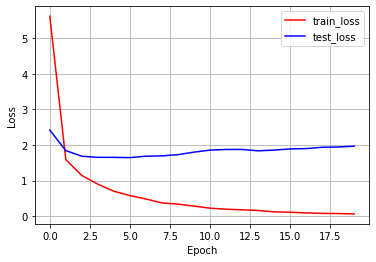

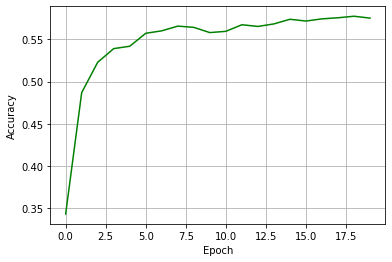

In [ ]:
# 学習データに対するロス、テストデータに対するロス
plt.figure()
plt.plot(range(NUM_EPOCHS), loss_list, 'r-', label='train_loss')
plt.plot(range(NUM_EPOCHS), val_loss_list, 'b-', label='test_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

#正解率
plt.figure()
plt.plot(range(NUM_EPOCHS), val_acc_list, 'g-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

**学習により獲得したモデルによる予測**


ランダムでテストデータから画像を取り出し、正解ラベルと予測ラベルがどのようになっているのか確認する。

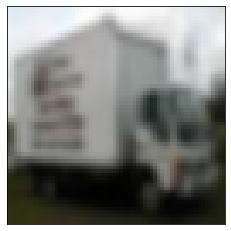

正解: truck 予測結果: truck


In [ ]:
dataiter = iter(DataLoader(test_datasets, shuffle=True))
images, labels = dataiter.next() #サンプルを1つだけ取り出す

plt.imshow(np.transpose(images[0], (1, 2, 0))) #チャンネルを一番後ろに
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False) #ラベルとメモリを非表示に
plt.show()

model.eval() #評価モード
imagee = images.to(device) #GPU対応
labele = labels.to(device) #GPU対応
with torch.no_grad():
  labely = model(imagee) #学習で獲得したmodelという変数を用いて分類
print("正解:", classes[labels[0]],"予測結果:", classes[labely.argmax().item()])

## 比較モデル実装(CNN)
転移学習の有用性を示すため、VGG19と同構造だが未学習のCNNモデルを用いた場合との比較を行う。

**データセットの準備**

転移学習と同様学習データセットを1000枚、テストデータを10000枚とする。

In [ ]:
#モジュールのインポート
import torch
from torch import nn
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2

#GPUチェック
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #デバイスとしてGPU(cuda)かCPUか判定
print("デバイスの種類：",device)

NUM_EPOCHS = 20 #学習時のエポック数
BATCH_SIZE = 16 #バッチサイズ
LEARNING_RATE = 0.001 #学習率

#transformの方法を定義。
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(), #画像データをTensorに変形
])

train_datasets = datasets.CIFAR10(root="cifar10data",
                                  train = True,
                                  download = True,
                                  transform=transform)
test_datasets =datasets.CIFAR10(root="cifar10data",
                          train=False,
                          download=True,
                          transform=transform)

print("---------処理前---------")
print("学習データ（画像）:",train_datasets.data.shape)
print("学習データ（ラベル）",len(train_datasets.targets))
print("検証データ（画像）:",test_datasets.data.shape)
print("検証データ（ラベル）",len(test_datasets.targets))

#データセットの量を1000枚に変更
train_datasets.data = train_datasets.data[:1000]
train_datasets.targets = train_datasets.targets[:1000]
print()
print("---------処理後---------")
print("学習データ（画像）:",train_datasets.data.shape)
print("学習データ（ラベル）",len(train_datasets.targets))
print("検証データ（画像）:",test_datasets.data.shape)
print("検証データ（ラベル）",len(test_datasets.targets))


#DataLoaderの作成
train_loader = DataLoader(train_datasets,
                           batch_size=BATCH_SIZE, 
                           shuffle=False)
test_loader = DataLoader(test_datasets,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

デバイスの種類： cuda
Files already downloaded and verified
Files already downloaded and verified
---------処理前---------
学習データ（画像）: (50000, 32, 32, 3)
学習データ（ラベル） 50000
検証データ（画像）: (10000, 32, 32, 3)
検証データ（ラベル） 10000

---------処理後---------
学習データ（画像）: (1000, 32, 32, 3)
学習データ（ラベル） 1000
検証データ（画像）: (10000, 32, 32, 3)
検証データ（ラベル） 10000


**学習モデル作成**

まず転移学習と同様VGG19_BNのモデルをダウンロードする。そしてそのパラメータを初期化することだけでネットワークの構造だけ活用することを実現している。

In [ ]:
#VGG19_BNを取得
model = models.vgg19_bn(pretrained=True)
model.classifier[6].out_features =10 #モデルの出力ノードを10個に変更

#VGG19のパラメータ初期化（ネット構造だけ使用）
for name, param in model.named_parameters():
    if 'weight' in name:
        nn.init.normal_(param, mean=0, std=0.01)
for name, param in model.named_parameters():
    if 'bias' in name:
        nn.init.constant_(param, val=0)

model = model.to(device)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

**学習実行**

Epoch 0, Loss: 2.8225 Val_loss: 2.3407 Val_acc: 0.1000
Epoch 1, Loss: 2.3464 Val_loss: 2.3212 Val_acc: 0.1000
Epoch 2, Loss: 2.3336 Val_loss: 2.2649 Val_acc: 0.1449
Epoch 3, Loss: 2.2320 Val_loss: 2.1781 Val_acc: 0.1823
Epoch 4, Loss: 2.1947 Val_loss: 2.2499 Val_acc: 0.1625
Epoch 5, Loss: 2.1581 Val_loss: 2.1101 Val_acc: 0.1742
Epoch 6, Loss: 2.1535 Val_loss: 2.0716 Val_acc: 0.1947
Epoch 7, Loss: 2.1276 Val_loss: 2.0758 Val_acc: 0.1945
Epoch 8, Loss: 2.0999 Val_loss: 2.0952 Val_acc: 0.2098
Epoch 9, Loss: 2.0916 Val_loss: 2.1465 Val_acc: 0.1592
Epoch 10, Loss: 2.0990 Val_loss: 2.0618 Val_acc: 0.2122
Epoch 11, Loss: 2.0738 Val_loss: 2.0455 Val_acc: 0.2274
Epoch 12, Loss: 2.0593 Val_loss: 2.0903 Val_acc: 0.2180
Epoch 13, Loss: 2.0592 Val_loss: 2.0440 Val_acc: 0.2333
Epoch 14, Loss: 2.0335 Val_loss: 2.0462 Val_acc: 0.2424
Epoch 15, Loss: 2.0468 Val_loss: 2.0291 Val_acc: 0.2449
Epoch 16, Loss: 2.0017 Val_loss: 2.0060 Val_acc: 0.2216
Epoch 17, Loss: 1.9883 Val_loss: 1.9881 Val_acc: 0.2526
Ep

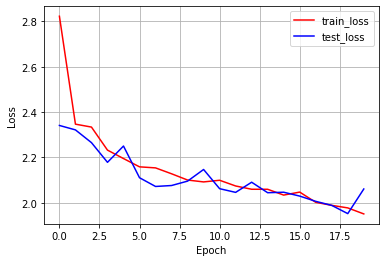

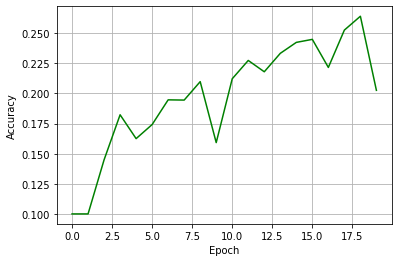

In [ ]:
import time
#損失関数、最適化アルゴリズム設定
criterion = nn.CrossEntropyLoss() #交差エントロピー誤差
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) #Adam

#学習実行
def train(train_loader):
    model.train() #訓練モードを指定
    running_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader): #学習データの画像、ラベルをDataLoaderから取得
        images = images.to(device) #GPUにいれる
        labels = labels.to(device) #GPUにいれる
        optimizer.zero_grad() #テンソル勾配のクリア
        outputs = model(images) #CNNモデルを用いて計算
        loss = criterion(outputs, labels) #ロス計算
        running_loss += loss.item()
        loss.backward() #誤差逆伝播
        optimizer.step() #パラメータ更新
    train_loss = running_loss / len(train_loader) 
    return train_loss

def valid(test_loader):
    model.eval() #評価モードを指定
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad(): #テンソルの勾配計算を不可能にすることでメモリの消費量を減らす、optimizer.zero_grad()がいらなくなる
        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = outputs.max(1, keepdim=True)[1]
            correct += predicted.eq(labels.view_as(predicted)).sum().item() #精度を計算
            total += labels.size(0)
    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    return val_loss, val_acc

loss_list = []
val_loss_list = []
val_acc_list = []
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    loss = train(train_loader)
    val_loss, val_acc = valid(test_loader)
    print('Epoch %d, Loss: %.4f Val_loss: %.4f Val_acc: %.4f' % (epoch, loss, val_loss, val_acc))
    #損失、精度をリストに格納
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
print("訓練終了")
end_time = time.time()
print("学習時間: "+str(end_time-start_time)+"s")

#学習性能評価
# 学習データに対するロス、テストデータに対するロス
plt.figure()
plt.plot(range(NUM_EPOCHS), loss_list, 'r-', label='train_loss')
plt.plot(range(NUM_EPOCHS), val_loss_list, 'b-', label='test_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

#正解率
plt.figure()
plt.plot(range(NUM_EPOCHS), val_acc_list, 'g-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

## 転移学習とCNNの比較
最後に、CIFAR-10のデータに対する転移学習とCNNの結果を比較する。<br>
双方の結果をまとめると以下のようになった。<br><br>

|  学習方法  |  正解率 (%)  |  20エポックの学習時間 (s)  |
| :----: | :----: | :----: |
|  CNN  |  26  |  864  |
|  転移学習  |  58  |  716  |

<br>

CNNと転移学習を比較すると、転移学習を用いることで精度、学習時間の改善という点で非常に大きな効果が出ていることが確認できる。<br>
このように、転移学習を用いることで、学習用データが少ない場合でも比較的高精度&短時間の学習を実現できていることが分かる。ディープラーニングを回す上で学習データを集めるのは非常に大変なため、データ集めが難しい場合には転移学習の利用を是非検討してみると良いと思う。<br>
ただし、転移学習概要でも述べたが、転移元と転移先の関連性が高くなければ負の転移により学習精度、速度の低下の懸念があるため、転移学習を用いれば全て解決するわけではないということも頭に入れておくと良い。

# 演習問題 CNNの実装(CIFAR-10)
演習問題では、CIFAR-10のデータセット60000枚全てを用いてCNNによる分類を行ってもらう。<br>
転移学習でCIFAR-10は用いており、かつその際に少ないデータセットに対してCNNの作成も行っているため、実装自体はあまり難易度は高くないと思う。そこで、どうすればCNNで学習性能の向上が図れるか試行錯誤しながら実装を行っていただきたい。
その際、第3回で学んだ学習のテクニックが非常にいきるので、是非第3回の講義と照らし合わせながら進めてほしい。<br><br>
また、学習性能を高める方法として、**画像の水増し**や**画像の標準化（正規化）**という方法がある。画像の水増しとは、画像を拡大縮小したり、回転させることによって、1枚の画像を複数のデータへと拡張する方法のことで、データセットを増やすことができるため学習性能の向上が期待できる。また、画像の標準化とは、画像全体を平均0、分散 1.0にすることで学習を効率化する方法である。このように、第3回で学んだ学習のテクニック以外にも有用なテクニックが様々ある。上記のテクニックは、データロード時に`transform = transforms.Compose([transforms.Resize(64),transforms.ToTensor()])`という形で設定することができる。transformで用いることができる関数（一部）を以下に示す。<br><br>

|  関数  |  処理内容  |
| ---- | ---- |
|  Resize |  画像サイズを変形  |
|  RandomAffine  |  画像の回転および拡大縮小  |
|  RandomResizedCrop  |  ランダムに切り抜き&リサイズ  |
|  RandomHorizontalFlip  |  画像の左右反転  |
|  RandomErasing  |  画像のランダムな一部分にノイズを付加  |
|  RandomPerspective  |  画像を確率pでランダムに視覚を変換  |
|  ToTensor  |  画像データをテンソルに変換  |
|  Normalize  |  画像データを標準化  |

<br>

その他にも学習性能の向上アルゴリズムは様々提案されているので、是非自分で調査&実装を行い学習性能の向上を目指して欲しい。<br>
また、演習問題の実装が終わったら、授業内で実装を行った転移学習の精度と比較してみると面白いだろう。